# package installation

In [4]:
!python3 -m pip install --upgrade pip
!pip install torchcam captum torch lime shap pytorch-gradcam grad-cam

## !unzip /content/drive/MyDrive/pancreas.zip

# data_preparation [ data class to load data set ]

In [1]:
# data_preparation.py

import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class PancreasTumorDataset(Dataset):

    def __init__(self, root_dir, transform=None, is_validation=False):
        self.root_dir = root_dir
        self.transform = transform
        self.is_validation = is_validation

        self.classes = ['neg', 'pos']  # Binary classification
        self.image_paths = []
        self.labels = []

        # to load images and labels
        # data_pancreas/image/
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, 'image', class_name)
            if os.path.exists(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png')):
                        self.image_paths.append(os.path.join(class_dir, img_name))
                        self.labels.append(label)

        print(f"Loaded {len(self.image_paths)} images")
        print(f"Class distribution: neg={self.labels.count(0)}, pos={self.labels.count(1)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        # since pancreas CT scans are grayscale, so loding image as grayscale
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Transforms specifically mapped for grayscale images
def get_transforms():
    # Training transforms with medical-specific augmentations
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        # Medical image specific augmentations
        transforms.RandomRotation(degrees=15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(p=0.5),
        # map tensor and normalize --> grayscale
        transforms.ToTensor(),
        # for grayscale images, normalize (mean=0.5, std=0.5 maps [0,1] to [-1,1])
        transforms.Normalize(mean=[0.5], std=[0.5]),
        # for model compatibility , single channel to 3 channels
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])

    # Validation transforms
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])

    return train_transform, val_transform

def prepare_data_loaders(dataset_path, batch_size=16, val_split=0.2):
    train_transform, val_transform = get_transforms()

    # full dataset
    full_dataset = PancreasTumorDataset(root_dir=dataset_path, transform=train_transform)

    # splitting dataset --> train & validation
    total_size = len(full_dataset)
    val_size = int(val_split * total_size)
    train_size = total_size - val_size

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Update validation dataset transform
    val_dataset.dataset.transform = val_transform

    # since the images are imbalanced [ neg=80, pos=281 ]
    # to calculate class weights
    labels = [full_dataset.labels[i] for i in range(len(full_dataset.labels))]
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.FloatTensor(class_weights)

    # forming data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=4,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2
    )

    # now for Valicdation
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )

    return train_loader, val_loader, class_weights

# model [ WideResNet - 50 ]

In [2]:
# model.py
import torch
import torch.nn as nn
from torchvision.models import wide_resnet50_2
import torch.nn.functional as F



class PancreasTumorDetector(nn.Module):
    def __init__(self, num_classes=1, dropout=0.5):
        super(PancreasTumorDetector, self).__init__()

        # Load pretrained WideResNet-50
        self.backbone = wide_resnet50_2(pretrained=True)

        num_features = self.backbone.fc.in_features

        # classifier with custom layers for binary classification
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout/2),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.backbone.fc.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Forward through layers, up to (and including) layer4
        # print('\n--------Inside PancreasTumorDetector Forward..........')
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)
        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.backbone.fc(x)
        return x

# Train & Fine-tune model

In [4]:
""" It is the Main entry point for model training
# train_model.py
"""

from logging import raiseExceptions
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
import numpy as np
from sklearn.metrics import ( accuracy_score, precision_recall_fscore_support, roc_auc_score,
                             confusion_matrix, precision_recall_curve, roc_curve, auc )
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from datetime import datetime

"""# Following 2 lines TO be uncommented while running in the local env"""

# from data_preparation import prepare_data_loaders
# from model import PancreasTumorDetector


class PancreasTumorTrainer:
    def __init__(self, model, train_loader, val_loader, class_weights, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device

        # Loss function with class weights for imbalanced data
        pos_weight = class_weights[1] / class_weights[0]
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]).to(device))

        # Optimizer, learning rates for different parts
        backbone_params = []
        classifier_params = []

        for name, param in model.named_parameters():
            if 'fc' in name:  # Classifier parameters
                classifier_params.append(param)
            else:  # Backbone parameters
                backbone_params.append(param)

        # Lower learning rate for pretrained backbone, higher for new classifier
        self.optimizer = optim.AdamW([
            {'params': backbone_params, 'lr': 1e-5},
            {'params': classifier_params, 'lr': 1e-3}
        ], weight_decay=1e-4)

        # Learning rate scheduler
        self.scheduler = ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=5, verbose=True
        )


        # -----------------------------Metrics tracking
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.val_aucs = []

        self.best_val_auc = 0.0
        self.best_model_path = None

    def train_epoch(self):
        """
        Function to train for one epoch
        """
        self.model.train()
        total_loss = 0.0
        num_batches = 0

        progress_bar = tqdm(self.train_loader, desc="Training")

        for images, labels in progress_bar:
            images, labels = images.to(self.device), labels.float().to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(images).squeeze(1)
            loss = self.criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            total_loss += loss.item()
            num_batches += 1

            # Update progress bar
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        return total_loss / num_batches

    def validate_epoch(self):
        """
        Function to Validate for one epoch
        """
        self.model.eval()
        total_loss = 0.0
        all_predictions = []
        all_probabilities = []
        all_labels = []

        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc="Validation"):
                images, labels = images.to(self.device), labels.float().to(self.device)

                outputs = self.model(images).squeeze(1)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()

                # Get predictions and probabilities
                probabilities = torch.sigmoid(outputs)
                predictions = (probabilities > 0.5).float()

                all_predictions.extend(predictions.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        #------------------------------------------Calculate metrics
        avg_loss = total_loss / len(self.val_loader)
        accuracy = accuracy_score(all_labels, all_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, all_predictions, average='binary'
        )

        try:
            auc = roc_auc_score(all_labels, all_probabilities)
        except ValueError:
            auc = 0.0  # In case of single class in validation

        return avg_loss, accuracy, precision, recall, f1, auc, all_labels, all_predictions

    def train(self, num_epochs=50, save_dir='trained_model'):
        """
        Fucntion for main training loop
        """
        os.makedirs(save_dir, exist_ok=True)

        # to learning tracking
        backbone_lrs = []
        classifier_lrs = []

        print(f"Starting training for {num_epochs} epochs...")
        print(f"Device: {self.device}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")

        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 30)

            # Training phase
            train_loss = self.train_epoch()


            backbone_lrs.append(self.optimizer.param_groups[0]['lr'])
            classifier_lrs.append(self.optimizer.param_groups[1]['lr'])

            # Validation phase
            val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, true_labels, pred_labels = self.validate_epoch()

            # Update learning rate scheduler
            self.scheduler.step(val_loss)

            # Store metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.val_accuracies.append(val_acc)
            self.val_aucs.append(val_auc)

            # Print epoch results
            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Val Accuracy: {val_acc:.4f}")
            print(f"Val Precision: {val_prec:.4f}")
            print(f"Val Recall: {val_rec:.4f}")
            print(f"Val F1: {val_f1:.4f}")
            print(f"Val AUC: {val_auc:.4f}")

            # Save best model
            if val_auc > self.best_val_auc:
                self.best_val_auc = val_auc
                self.best_model_path = os.path.join(save_dir, f'new_best_wideresnet50_model_epoch_{epoch+1}.pth')
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_auc': val_auc,
                    'val_accuracy': val_acc,
                }, self.best_model_path)
                print(f"New best model saved! AUC: {val_auc:.4f}")

            # # Save regular checkpoint every 5 epochs
            # if (epoch + 1) % 5 == 0:
            #     checkpoint_path = os.path.join(save_dir, f'new_best_wideresnet50_model_epoch_{epoch+1}.pth')
            #     torch.save({
            #         'epoch': epoch + 1,
            #         'model_state_dict': self.model.state_dict(),
            #         'optimizer_state_dict': self.optimizer.state_dict(),
            #         'train_losses': self.train_losses,
            #         'val_losses': self.val_losses,
            #         'val_accuracies': self.val_accuracies,
            #         'val_aucs': self.val_aucs,
            #     }, checkpoint_path)

        print(f"\nTraining completed! Best validation AUC: {self.best_val_auc:.4f}")
        print(f"Best model saved at: {self.best_model_path}")

        # Plot training curves
        self.plot_training_curves(backbone_lrs, classifier_lrs, true_labels,
                                  pred_labels, val_f1)#, val_prec, val_rec)

        return self.best_model_path

    def plot_format_axis(self, ax, title=None, xlabel=None, ylabel=None):
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        if ylabel is not None:
            ax.set_ylabel(ylabel)
        # added legend, to describe, labels
        ax.legend()
        ax.grid(True)


    def plot_training_curves(self, backbone_lrs, classifier_lrs, true_labels, pred_labels, val_f1):#, precision, recall):
        """Plot training and validation curves"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

        epochs = range(1, len(self.train_losses) + 1)

        # Training & Valdation Plot
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        ax1.plot(epochs, self.val_losses, 'r-', label='Validation Loss')
        self.plot_format_axis(ax=ax1, title=f'Training and Validation Loss)', xlabel='Epochs',
                              ylabel='Loss')#, legend=True, grid=True)


        # ACCURACY PLOT
        ax2.plot(epochs, self.val_accuracies, 'g-', label='Validation Accuracy')
        self.plot_format_axis( ax=ax2, title=f'Validation Accuracy',
            xlabel='Epochs', ylabel='Accuracy') # legend=True, # grid=True )

        # AUC PLOT
        ax3.plot(epochs, self.val_aucs, 'm-', label='Validation AUC')
        self.plot_format_axis(
            ax=ax3, title=f'Validation AUC',
            xlabel='Epochs', ylabel='AUC') # legend=True,  grid=True )

        # LEARNING RATE PLOT
        ax4.plot(epochs, backbone_lrs, 'b-', label='Backbone LR')
        ax4.plot(epochs, classifier_lrs, 'r-', label='Classifier LR')
        ax4.set_yscale('log')
        self.plot_format_axis( ax=ax4, title=f'Learning Rates',
            xlabel='Epochs', ylabel='Learning Rate (log)') # legend=True, grid=True )

        # Add unified annotation
        fig.suptitle(f'Model Training Summary', y=1.02, fontsize=14)


        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

def main():
    # Configuration & Constants
    DATASET_PATH = '/content/pancreas/'
    BATCH_SIZE = 20
    NUM_EPOCHS = 20
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Using device: {DEVICE}")

    # preparing data
    train_loader, val_loader, class_weights = prepare_data_loaders(DATASET_PATH, BATCH_SIZE)

    # initializing the model
    model = PancreasTumorDetector(num_classes=1, dropout=0.5)
    model.to(DEVICE)

    # initializing trainer
    trainer = PancreasTumorTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        class_weights=class_weights,
        device=DEVICE
    )

    # training
    best_model_path = trainer.train(num_epochs=NUM_EPOCHS)

    print(f"\nTraining completed. Best models saved at: {best_model_path}")


if __name__ == "__main__":
    main()



#       - - - -XAI Methods - - - -

In [4]:
!pip install captum pytorch-gradcam grad-cam lime scikit-image



# [ 1 ] Integrated Grad

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


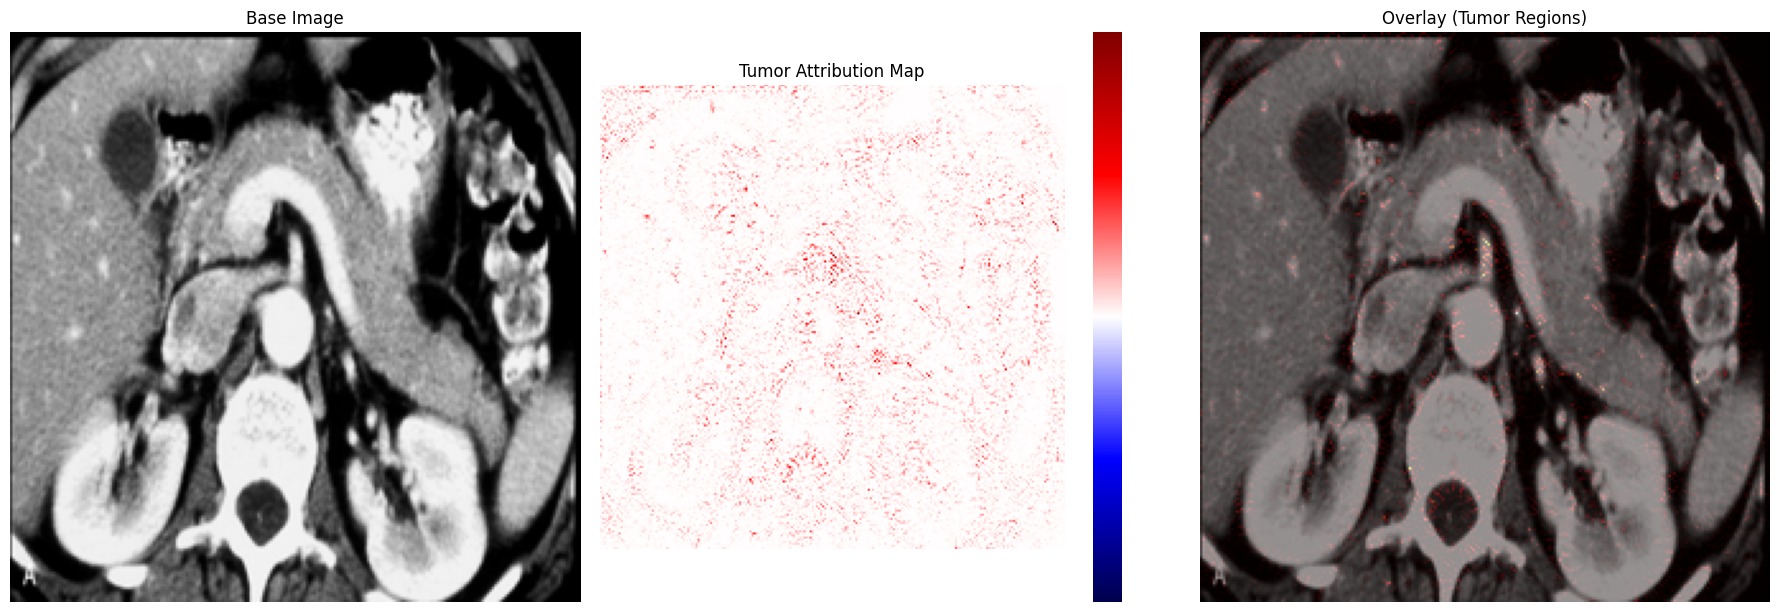


Predicted: Tumor


In [3]:
# !pip install captum

"""----------------------# RUN CELLS - data_preparation,  model & XAI Methods cell"""
import torch
from PIL import Image
import numpy as np
from torchvision import transforms
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt


def model_ig_analysis(model, img_path, n_steps=200):
    """Enhanced IG for tumor localization in medical images"""
    device = next(model.parameters()).device
    img = Image.open(img_path).convert('L').resize((224, 224))
    img_np = np.array(img).astype(np.float32) / 255.0

    # preprocessing
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        pred_prob = torch.sigmoid(output).item()
        pred_class = int(pred_prob > 0.5)

    # baseline: Gaussian blur
    baseline = transforms.GaussianBlur(kernel_size=15, sigma=5)(img_tensor)

    ig = IntegratedGradients(model)
    attributions = ig.attribute(
        inputs=img_tensor,
        baselines=baseline,
        target=0 if pred_class == 1 else None,  # Explicit tumor target
        n_steps=n_steps
    )

    # Process attributions correctly
    attr = attributions.squeeze(0).mean(dim=0).cpu().numpy()  # taking, Mean across channels
    attr = np.maximum(attr, 0)  # Only positive attributions (tumor evidence)
    attr_norm = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)


    # --------------visualization-------------------
    plt.figure(figsize=(18, 6))

    # Original
    plt.subplot(1, 3, 1)
    plt.imshow(img_np, cmap='gray')
    # plt.title(f"Base Image \nPred: {'Tumor' if pred_class else 'Normal'} ({pred_prob:.2f})")
    plt.title(f"Base Image")

    # Tumor Evidence Heatmap
    plt.subplot(1, 3, 2)
    vmax = np.abs(attr).max()
    plt.imshow(attr, cmap='seismic', vmin=-vmax, vmax=vmax)
    plt.colorbar(label='Tumor Evidence')
    plt.title("Tumor Attribution Map")

    # Overlay
    plt.subplot(1, 3, 3)
    plt.imshow(img_np, cmap='gray')
    tumor_mask = np.where(attr > 0, attr, 0)  # Only show positive attributions
    plt.imshow(tumor_mask, cmap='hot', alpha=0.4, vmin=0)
    plt.title("Overlay (Tumor Regions)")

    for ax in plt.gcf().axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    return {
        'attributions': attr,
        'prediction': pred_class,
        'probability': pred_prob,
        'tumor_mask': tumor_mask
    }



def main():

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    TRAINED_MODEL_PATH = '/content/drive/MyDrive/new_best_wideresnet50_model_epoch_20.pth'

    TO_TEST_IMAGE_PATH = "/content/test_xai_method.png"
    # modelpath = '/content/trained_model/new_best_wideresnet50_model_epoch_4.pth'
    # # Load model
    model_ig = PancreasTumorDetector().to(DEVICE)


    modelpoint = torch.load(TRAINED_MODEL_PATH, map_location=DEVICE, weights_only=False)
    model_ig.load_state_dict(modelpoint['model_state_dict'])

    # Analyze a tumor image
    results = model_ig_analysis(
        model=model_ig,
        img_path="/content/test_xai_method.png",
        # img_path="/content/test_xai_method_pos.png",

        #"""TO get a better, one can imcrease the value of n_steps"""
        n_steps=50  # Smoother attributions
    )

    print(f"\nPredicted: {'Tumor' if results['prediction'] else 'Normal'}")


if __name__ == "__main__":
    main()


 #"""Inside the main(), TO get a better, one can imcrease the value of n_steps"""

# [ 2 ] LIME

  0%|          | 0/200 [00:00<?, ?it/s]

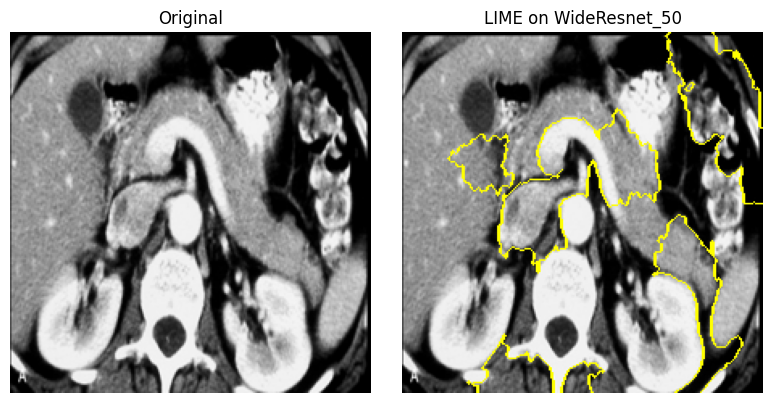

In [ ]:

"""----------------------# RUN CELLS - data_preparation,  model & XAI Methods cell"""

import torch
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt


# Visualizing LIME

def visualize_lime(img_rgb, model_l,transform, DEVICE, num_samples=100):

    # # LIME Predictions,
    def batch_predict(images):
        model_l.eval()
        batch = []
        for img in images:
            pil_img = Image.fromarray(img.astype('uint8')).convert('L').resize((224, 224))
            tensor_img = transform(pil_img).repeat(3, 1, 1).unsqueeze(0)  # [1,3,224,224]
            batch.append(tensor_img)
        batch = torch.cat(batch, dim=0).to(DEVICE)
        with torch.no_grad():
            logits = model_l(batch).squeeze(1)  # [N]
            probs = torch.sigmoid(logits).cpu().numpy()  # [N]
        # LIME expects (N, 2): [P(neg), P(pos)]
        probs = np.stack([1-probs, probs], axis=1)
        return probs

    explainer = lime_image.LimeImageExplainer()

    explanation = explainer.explain_instance(
                          img_rgb.astype('double'),
                          batch_predict,
                          labels=(1,),           # 1 = 'tumor', 0 = 'no tumor'
                          hide_color=0,
                          num_samples=num_samples
                      )

    temp, mask = explanation.get_image_and_mask(
                          # image and mask for the 'tumor' class (label=1)
                          label=1,
                          positive_only=True,

                          # LIME maps to these
                          num_features=10,

                          # Flag for visibility
                          hide_rest=False
                      )

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.title('Original')
    plt.imshow(img_rgb, cmap='gray')
    plt.axis('off')

    plt.subplot(1,2,2)

    plt.title('LIME on WideResnet_50')
    plt.imshow(mark_boundaries(temp, mask))
    plt.axis('off')

    plt.tight_layout()
    plt.show()


def main():

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    TRAINED_MODEL_PATH = '/content/drive/MyDrive/new_best_wideresnet50_model_epoch_3.pth'

    TO_TEST_IMAGE_PATH = "/content/test_xai_method.png"


    # RUN above cells - data_preparation & model
    model_fr_Lime = PancreasTumorDetector()
    checkpoint = torch.load(TRAINED_MODEL_PATH,
                            map_location=DEVICE, weights_only=False)
    model_fr_Lime.load_state_dict(checkpoint['model_state_dict'])
    model_l = model_fr_Lime.to(DEVICE)

    # Load the image you attached (already grayscale)
    img = Image.open(TO_TEST_IMAGE_PATH).convert('L').resize((224, 224))
    img_np = np.array(img).astype(np.float32) / 255.0
    img_rgb = np.stack([img_np]*3, axis=-1)  # (224,224,3) for LIME


    # # Use the same transform as your model expects
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])

    NUM_SAMPLES = 200 # FOR EXPLANATIONS of features

    # to analyse and plot
    visualize_lime(img_rgb, model_l, transform, DEVICE, NUM_SAMPLES)

    # return img_rgb, model_l, DEVICE

if __name__ == "__main__":
    main()


# [ 3 ] Grad-CAM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pytorch-gradcam: filename=pytorch_gradcam-0.2.1-py3-none-any.whl size=5249 sha256=53e7870a9d760fe59de88e0327667028312b1c755f33da2c1e8ba596fd44cb91
  Stored in directory: /root/.cache/pip/wheels/20/d6/4e/1ac02c54faee563b4d06015456c6c5d85550dcec878740f37d
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=33f2d4cef4eda3a20a61d8db39f7145179a0a1b762c1fc321cb6340d2fe564ac
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built pytorch-gradcam grad-cam


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


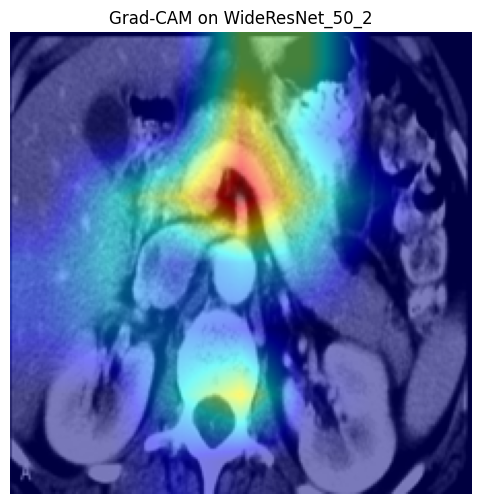

In [ ]:

"""----------------------# RUN CELLS - data_preparation,  model & XAI Methods cell"""
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt



def visualize_grad_cam(img_tensor, model_gc, img_rgb):
    target_layer = model_gc.backbone.layer4[-1]

    cam = GradCAM(model=model_gc, target_layers=[target_layer])
                  # use_cuda=torch.cuda.is_available())
    grayscale_cam = cam(input_tensor=img_tensor, targets=None)[0]  # shape (224,224)

    # Overlay CAM on image
    visualization = show_cam_on_image(img_rgb, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(6,6))
    plt.imshow(visualization)
    plt.axis('off')

    plt.title("Grad-CAM on WideResNet_50_2")
    plt.show()

def main():

    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    TRAINED_MODEL_PATH = '/content/drive/MyDrive/new_best_wideresnet50_model_epoch_3.pth'
    TO_TEST_IMAGE_PATH = "/content/test_xai_method.png"

    model_grad_cam = PancreasTumorDetector()

    checkpoint = torch.load(TRAINED_MODEL_PATH, map_location=DEVICE,
                            weights_only=False)
    model_grad_cam.load_state_dict(checkpoint['model_state_dict'])
    model_gc = model_grad_cam.to(DEVICE)
    # model.eval()

    img = Image.open(TO_TEST_IMAGE_PATH).convert('L').resize((224, 224))
    img_np = np.array(img).astype(np.float32) / 255.0
    img_rgb = np.stack([img_np]*3, axis=-1)  # (224, 224, 3)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
    img_tensor = transform(img)           # [1,224,224]
    img_tensor = img_tensor.repeat(3,1,1) # [3,224,224]
    img_tensor = img_tensor.unsqueeze(0).to(DEVICE)  # [1,3,224,224]

    visualize_grad_cam(img_tensor, model_gc, img_rgb)

if __name__ == "__main__":
    main()
